<a href="https://colab.research.google.com/github/Yarida-nes/weatherwise-Yarida-Kaewthong/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [10]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existi

In [11]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: Perth


## 📦 Setup and Configuration
Import required packages and setup environment.

In [13]:
import requests
import matplotlib.pyplot as plt
# Install pyinputplus if not already installed
!pip install pyinputplus
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=da85adfda8d6c041a948a6fd7b72506c1896422238d35be8ef2cb8ec1552d71c
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=2ed72ac4b3278b119b0dcb96b1bdd123af80f9ad67d79d75c67ef87d9a2afd17
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 🌤️ Weather Data Functions

In [38]:
# Define get_weather_data() function here
from fetch_my_weather import get_weather

def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
        data = get_weather(location)  # fetch data

        # Handle case where no data is returned
        if not data:
            return {"error": "Location not found"}

        # Access data as a dictionary
        data_dict = data.dict()

        # Keep only requested forecast days
        data_dict["forecast"] = data_dict.get("forecast", [])[:forecast_days]
        return data_dict

    except Exception as e:
        return {"error": str(e)}

In [94]:
import requests

def get_weather_data(location, forecast_days=3):
    """
    Retrieve weather data for a specified location using wttr.in API directly.
    """
    try:
        url = f"https://wttr.in/{location}?format=j1"
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()

        current = data.get("current_condition", [{}])[0]

        forecast = data.get("weather", [])[:forecast_days]
        if not forecast:  # fallback if forecast missing
            forecast = [{
                "date": "N/A",
                "maxtempC": current.get("temp_C", "N/A"),
                "mintempC": current.get("temp_C", "N/A"),
                "hourly": [{"chanceofrain": current.get("humidity", "0")}]
            }]

        return {
            "location": location,
            "current": {
                "temp_C": current.get("temp_C", "N/A"),
                "humidity": current.get("humidity", "N/A"),
                "description": current.get("weatherDesc", [{}])[0].get("value", "unknown")
            },
            "forecast": forecast
        }

    except Exception as e:
        return {"error": str(e)}

In [95]:
sample = get_weather_data("Perth", forecast_days=3)
print("Current block:", sample["current"])

Current block: {'temp_C': '14', 'humidity': '59', 'description': 'Sunny'}


## 📊 Visualisation Functions

In [96]:
# Define create_temperature_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
     # Step 1: Get forecast safely
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    # Step 2: Extract dates and temperatures
    days = [day["date"] for day in forecast]
    max_temps = [int(day.get("maxtempC", 0)) for day in forecast]
    min_temps = [int(day.get("mintempC", 0)) for day in forecast]

    # Step 3: Create chart
    fig, ax = plt.subplots()
    ax.plot(days, max_temps, label="Max Temp (°C)", marker="o", color="red")
    ax.plot(days, min_temps, label="Min Temp (°C)", marker="o", color="blue")

    ax.set_title(f"Temperature Forecast – {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("°C")
    ax.legend()

    # Step 4: Show or return
    if output_type == 'figure':
        return fig
    else:
        plt.show()

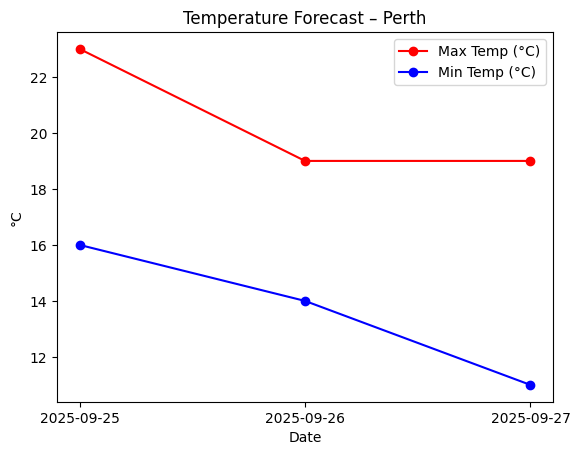

In [97]:
sample = get_weather_data("Perth", forecast_days=3)
create_temperature_visualisation(sample)

In [98]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """

    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    days = [day["date"] for day in forecast]
    precip = [max(int(hour.get("chanceofrain", 0)) for hour in day.get("hourly", []))
        for day in forecast]

    fig, ax = plt.subplots()
    bars = ax.bar(days, precip, color="skyblue")
    for bar, value in zip(bars, precip):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 2,
            f"{value}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color="blue"
    )

    ax.set_title(f"Chance of Rain – {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)  # Keep consistent scale
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    if output_type == 'figure':
        return fig
    else:
        plt.show()

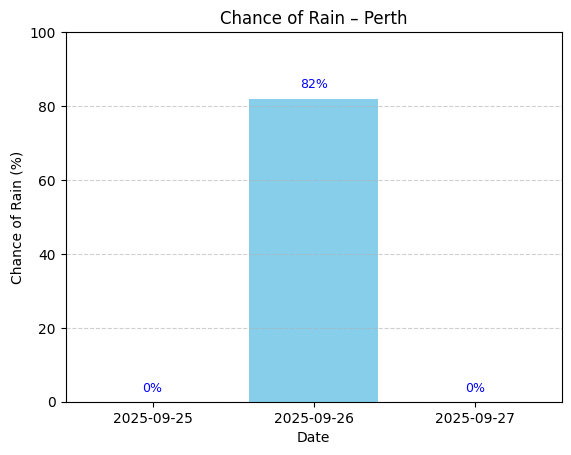

In [99]:
sample = get_weather_data("Perth", forecast_days=3)
create_precipitation_visualisation(sample)

## 🤖 Natural Language Processing

In [59]:
# Define parse_weather_question() and generate_weather_response() here
import re

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    q = question.lower()

    parsed = {
        "location": "Perth",
        "attribute": "temp",
        "time": "today"
    }
    print(generate_weather_response(parsed, sample))
    if "tomorrow" in q:
        parsed["time"] = "tomorrow"

    if "rain" in q or "umbrella" in q or "precip" in q:
        parsed["attribute"] = "rain"
    elif "humidity" in q:
        parsed["attribute"] = "humidity"
    elif "temp" in q or "hot" in q or "cold" in q:
        parsed["attribute"] = "temp"

    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = parsed_question["location"]


    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."


    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    elif attr == "rain":
        chance = forecast[day_idx].get("hourly", [{}])[0].get("chanceofrain", "0")
        chance = int(chance)


        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."

        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    else:
        return "⚠️ Sorry, I couldn't understand your question."

In [60]:
sample = get_weather_data("Perth", forecast_days=3)

questions = [
    "What is the temperature today in Perth?",
    "Should I take an umbrella tomorrow?",
    "What is the chance of rain in Perth?",
    "What is the humidity today in Perth?"
]

for q in questions:
    parsed = parse_weather_question(q)
    print("Q:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))
    print("-----")

Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the temperature today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Perth, the temperature will be around 14°C with sunny.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: Should I take an umbrella tomorrow?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Perth, the chance of rain is 0%. No umbrella needed.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the chance of rain in Perth?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'today'}
Answer: Today in Perth, the chance of rain is 0%. No umbrella needed.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the humidity today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Perth, the humidity is 59%.
-----


## 🧭 User Interface

In [68]:
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip

def run_app():
    """
    WeatherWise main menu using pyinputplus (Perth-only version).
    """
    while True:

        choice = pyip.inputMenu(
            ['Current Weather (Perth)',
             'Forecast Charts (Perth)',
             'Ask a Question (Perth)',
             'Exit'],
            numbered=True
        )


        if choice == 'Current Weather (Perth)':
            data = get_weather_data("Perth", forecast_days=3)
            print("\n🌡️ Current Weather in Perth:")
            print(f"Temperature: {data['current']['temp_C']}°C")
            print(f"Humidity: {data['current']['humidity']}%")
            print(f"Conditions: {data['current']['description']}")

        elif choice == 'Forecast Charts (Perth)':
            data = get_weather_data("Perth", forecast_days=3)
            print("\n📊 Generating charts...")
            create_temperature_visualisation(data)
            create_precipitation_visualisation(data)

        elif choice == 'Ask a Question (Perth)':
            data = get_weather_data("Perth", forecast_days=3)
            q = input("❓ Ask your weather question about Perth: ")
            parsed = parse_weather_question(q)
            print("🤖", generate_weather_response(parsed, data))

        elif choice == 'Exit':
            print("\n👋 Goodbye! Have a great day 🌤️")
            break

Please select one of the following:
1. Current Weather (Perth)
2. Forecast Charts (Perth)
3. Ask a Question (Perth)
4. Exit
2

📊 Generating charts...


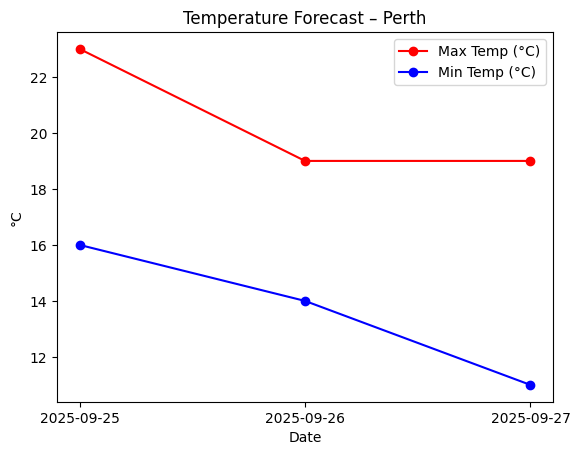

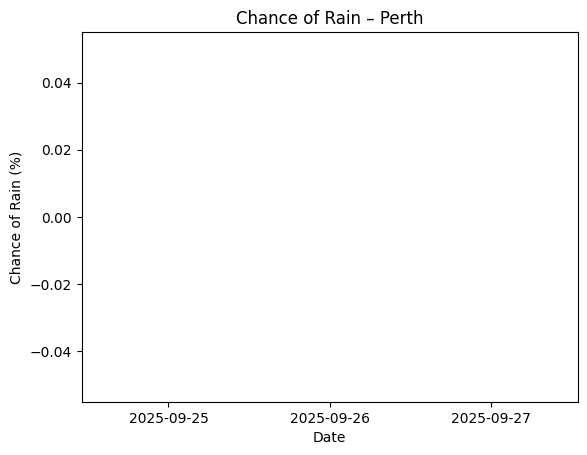

Please select one of the following:
1. Current Weather (Perth)
2. Forecast Charts (Perth)
3. Ask a Question (Perth)
4. Exit
4

👋 Goodbye! Have a great day 🌤️


In [69]:
run_app()

## 🧩 Main Application Logic

In [70]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """

    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = parsed_question["location"]


    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."


    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    elif attr == "rain":
        chance = forecast[day_idx].get("hourly", [{}])[0].get("chanceofrain", "0")
        chance = int(chance)


        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."

        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    else:
        return "⚠️ Sorry, I couldn't understand your question."

In [71]:
sample = get_weather_data("Perth", forecast_days=3)

questions = [
    "What is the temperature today in Perth?",
    "Should I take an umbrella tomorrow?",
    "What is the chance of rain in Perth?",
    "What is the humidity today in Perth?"
]

for q in questions:
    parsed = parse_weather_question(q)
    print("Q:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))
    print("-----")

Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the temperature today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Perth, the temperature will be around 14°C with sunny.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: Should I take an umbrella tomorrow?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Perth, the chance of rain is 0%. No umbrella needed.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the chance of rain in Perth?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'today'}
Answer: Today in Perth, the chance of rain is 0%. No umbrella needed.
-----
Today in Perth, the temperature will be around 14°C with sunny.
Q: What is the humidity today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Perth, the humidity is 59%.
-----


## 🧪 Testing and Examples

🔎 Testing Weather Data Fetch...
Location: Perth
Current: {'temp_C': '14', 'humidity': '59', 'description': 'Sunny'}
Forecast length: 3
📊 Testing Temperature Visualisation...


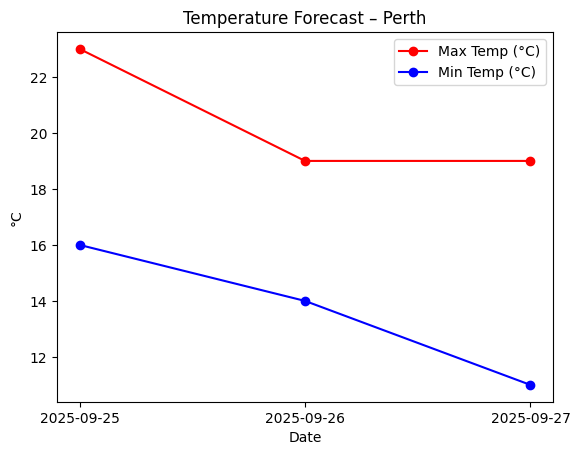

🌧️ Testing Precipitation Visualisation...


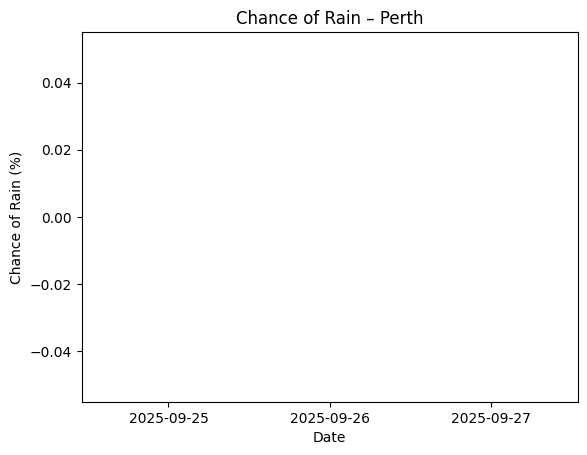

🤖 Testing Q&A...
Today in Perth, the temperature will be around 14°C with sunny.

Q: What is the temperature today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Perth, the temperature will be around 14°C with sunny.
Today in Perth, the temperature will be around 14°C with sunny.

Q: Should I take an umbrella tomorrow?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Perth, the chance of rain is 0%. No umbrella needed.
Today in Perth, the temperature will be around 14°C with sunny.

Q: What is the chance of rain in Perth?
Parsed: {'location': 'Perth', 'attribute': 'rain', 'time': 'today'}
Answer: Today in Perth, the chance of rain is 0%. No umbrella needed.
Today in Perth, the temperature will be around 14°C with sunny.

Q: What is the humidity today in Perth?
Parsed: {'location': 'Perth', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Perth, the humidity is 59%.
🖥️ Testing Menu (manua

In [72]:
# Include sample input/output for each function
# Test the Weather Data
print("🔎 Testing Weather Data Fetch...")
sample = get_weather_data("Perth", forecast_days=3)

print("Location:", sample["location"])
print("Current:", sample["current"])
print("Forecast length:", len(sample["forecast"]))

# Test Temperature Chart
print("📊 Testing Temperature Visualisation...")
create_temperature_visualisation(sample)

# Test Precipation Chart

print("🌧️ Testing Precipitation Visualisation...")
create_precipitation_visualisation(sample)

# Test Natural Language processing
print("🤖 Testing Q&A...")
questions = [
    "What is the temperature today in Perth?",
    "Should I take an umbrella tomorrow?",
    "What is the chance of rain in Perth?",
    "What is the humidity today in Perth?"
]

for q in questions:
    parsed = parse_weather_question(q)
    print("\nQ:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))

# Test Menu System
print("🖥️ Testing Menu (manual interaction required)...")
# Run the interactive menu app
run_app()

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.